In [1]:
import numpy as np
import json
import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

In [2]:
def initialize_parameters(layer_dims):

    L = len(layer_dims)
    parameters = {}
    print("Initializing parameters....")

    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        parameters["b" + str(l)] = np.zeros([layer_dims[l],1])

        assert(parameters["W" + str(l)].shape == (layer_dims[l],layer_dims[l-1]))
        assert(parameters["b" + str(l)].shape == (layer_dims[l],1))
        
    print("Parameters Initialized....")

    for i in range(1, L):
        print("Sahpe of W{} : ".format(i), parameters["W" + str(i)].shape)

    return parameters

In [3]:
temp_parameters = initialize_parameters([784, 16, 16, 10])

Initializing parameters....
Parameters Initialized....
Sahpe of W1 :  (16, 784)
Sahpe of W2 :  (16, 16)
Sahpe of W3 :  (10, 16)


In [4]:
def initialize_trainingSet():
    
    #retrieving files...
    print("Retrieving Files....")
    
    train_X = pd.read_csv("mnist_train.csv").drop(columns="5").values
    train_Y = pd.read_csv("mnist_train.csv").loc[:, "5"].values
    test_X = pd.read_csv("mnist_test.csv").drop(columns="7").values
    test_Y = pd.read_csv("mnist_test.csv").loc[:, "7"].values
    
    print("Files Retrieved....")
    
    #reshaping the files into appropriate dimensions...
    
    train_X_orig = np.reshape(train_X, (train_X.shape[0], train_X.shape[1])).T
    train_Y_orig = np.reshape(train_Y, (train_Y.shape[0], 1)).T
    train_Y_orig = np.eye(10)[train_Y_orig].T
    train_Y_orig = np.reshape(train_Y_orig, (train_Y_orig.shape[0], train_Y_orig.shape[1] * train_Y_orig.shape[2]))
    
    test_X_orig = np.reshape(test_X, (test_X.shape[0], test_X.shape[1])).T
    test_Y_orig = np.reshape(test_Y, (test_Y.shape[0], 1)).T
    test_Y_orig = np.eye(10)[test_Y_orig].T
    test_Y_orig = np.reshape(test_Y_orig, (test_Y_orig.shape[0], test_Y_orig.shape[1] * test_Y_orig.shape[2]))
    
    return train_X_orig, train_Y_orig, test_X_orig, test_Y_orig

In [ ]:
temp_train_X_orig, temp_train_Y_orig, temp_test_X_orig, temp_test_Y_orig = initialize_trainingSet()

print("Shape of train_X : ", temp_train_X_orig.shape, " Type : ", type(temp_train_X_orig))
print("Shape of train_Y : ", temp_train_Y_orig.shape, " Type : ", type(temp_train_Y_orig))
print("Shape of test_X : ", temp_test_X_orig.shape, " Type : ", type(temp_test_X_orig))
print("Shape of test_Y : ", temp_test_Y_orig.shape, " Type : ", type(temp_test_Y_orig))

while True:
    inp = int(input("Enter the example no. : "))
    if inp == -1:
        break
    img = temp_train_X_orig[:, inp].reshape(28,28)
    print("Label : ", list(temp_train_Y_orig[:, inp]).index(1))
    
    plt.imshow(img)
    plt.show()

In [5]:
def non_linear_activation(Z, activation):
    
    if activation == "relu":
        Z = np.maximum(0, Z)
    elif activation == "softmax":
        Z = np.exp(Z)
        Z_sum = np.sum(Z, axis=0)
        Z = Z/Z_sum
    return Z

In [6]:
def forward_propagation(X, parameters, layer_dims):

    '''
    shape of X = (784, 59999)
    shape of W1 = (16, 784)
    shape of W2 = (16, 16)
    shape of W3 = (10, 16)
    layer_dims length = 4
    '''
    
    L = len(layer_dims)
    cache = {}
    cache["A0"] = X
    A = X
    
    for l in range(1, L):
        cache["Z" + str(l)] = np.dot(parameters["W" + str(l)], A) + parameters["b" + str(l)]
        cache["A" + str(l)] = non_linear_activation(cache["Z" + str(l)], activation = "relu")

        assert(cache["Z" + str(l)].shape == cache["A" + str(l)].shape)
        A = cache["A" + str(l)]
        
    cache["A" + str(L - 1)] = non_linear_activation(cache["Z" + str(L - 1)], activation = "softmax")
    assert(cache["Z" + str(L - 1)].shape == cache["A" + str(L - 1)].shape)
    
    return cache

In [ ]:
temp_layer_dims = [784, 35, 20, 25, 30, 10]
temp_parameters = initialize_parameters(temp_layer_dims)
temp_cache = forward_propagation(temp_train_X_orig, temp_parameters, temp_layer_dims)

for i in range(1, len(temp_layer_dims)):
    print("Shape of Z{} : ".format(i), temp_cache["Z" + str(i)].shape, " Shape of A{} : ".format(i), temp_cache["A" + str(i)].shape)

In [7]:
def compute_cost(Y, AL, layer_dims, parameters, lmbd = 0.05):

    '''
    Shape of Y :  (no. of output units, no. of examples)
    Shape of AL :  (no. of output units, no. of examples)
    '''
    m = int(Y.shape[1])
    L = len(layer_dims)
    
    regularized_term = 0
    for l in range(1, L):
        regularized_term = regularized_term + np.sum(np.square(parameters["W" + str(l)]))
    
    cost = (-1/m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply((1 - Y), np.log(1 - AL))) + (lmbd * regularized_term)/(2 * m)
    cost = np.squeeze(cost)  
    
    return cost

In [ ]:
cost_log = []
cost_log.append(compute_cost(temp_train_Y_orig, temp_cache["A" + str(len(temp_layer_dims) - 1)], temp_layer_dims, temp_parameters, lmbd = 0.05))
print(cost_log)

In [8]:
def relu_derivative(Z):
    Z[Z <= 0] = 0
    Z[Z > 0] = 1
    return Z

In [9]:
def backpropagate(parameters, cache, layer_dims, Y, lmbd = 0.05):

    grads = {}
    L = len(layer_dims) - 1
    
    m = int(Y.shape[1])
    
    grads["dZ{}".format(L)] = (cache["A{}".format(L)] - Y)
    grads["dW{}".format(L)] = (1/m) * np.dot(grads["dZ{}".format(L)], cache["A{}".format(L - 1)].T)
    grads["db{}".format(L)] = (1/m) * np.sum(grads["dZ{}".format(L)], axis=1, keepdims=True)
    
    W = parameters["W{}".format(L)]
    dZ = grads["dZ{}".format(L)]
    for l in range(1, L):
        
        grads["dA" + str(L - l)] = np.dot(W.T, dZ) 
        grads["dZ" + str(L - l)] = (grads["dA" + str(L - l)] * relu_derivative(cache["Z" + str(L - l)]))
        grads["dW" + str(L - l)] = ((1/m) * np.dot(grads["dZ" + str(L - l)], cache["A" + str(L - l - 1)].T)) + ((lmbd * parameters["W" + str(L - l)])/m)
        grads["db" + str(L - l)] = (1/m) * np.sum(grads["dZ" + str(L - l)], axis=1, keepdims=True)
        
        assert(grads["dA" + str(L - l)].shape == cache["A" + str(L - l)].shape)
        assert(grads["dZ" + str(L - l)].shape == cache["Z" + str(L - l)].shape)
        assert(grads["dW" + str(L - l)].shape == parameters["W" + str(L - l)].shape)
        assert(grads["db" + str(L - l)].shape == parameters["b" + str(L - l)].shape)
        
        W = parameters["W" + str(L - l)]
        dZ = grads["dZ" + str(L - l)]

    return grads

In [ ]:
temp_grads = backpropagate(temp_parameters, temp_cache, temp_layer_dims, temp_train_Y_orig)

for i in range(1, len(temp_layer_dims)):
    print("Shape of dW{} : ".format(i), temp_grads["dW" + str(i)].shape, ", Shape of W{} : ".format(i), temp_parameters["W" + str(i)].shape)

In [10]:
def update_parameters(grads, parameters, learning_rate = 0.003):
    
    L = len(layer_dims)

    for i in range(1,L):
        
        parameters["W" + str(i)] = parameters["W" + str(i)] - (learning_rate * grads["dW" + str(i)])
        parameters["b" + str(i)] = parameters["b" + str(i)] - (learning_rate * grads["db" + str(i)])

    return parameters

In [19]:
def model(train_X, train_Y, layer_dims, learning_rate, num_iterations = 3000, print_cost=False):
    
    # initialize_parameters(layer_dims)
    # non_linear_activation(Z, activation)
    # forward_propagation(X, parameters, layer_dims)
    # compute_cost(Y, AL, layer_dims, parameters, lmbd = 0.05)
    # relu_derivative(Z)
    # backpropagate(parameters, cache, layer_dims, Y, lmbd = 0.05)
    # update_parameters(parameters, grads, learning_rate = 0.003)
    
    m = train_X.shape[1]
    costs = []
    L = len(layer_dims)
    parameters = initialize_parameters(layer_dims)

    for epoch in range(num_iterations):
        cache = forward_propagation(train_X, parameters, layer_dims)
        AL = cache["A" + str(L - 1)]
        cost = compute_cost(train_Y, AL, layer_dims, parameters, lmbd = 0.05)
        grads = backpropagate(parameters, cache, layer_dims, train_Y, lmbd = 0.05)
        parameters = update_parameters(grads, parameters, learning_rate = 0.003)
        costs.append(cost)

        if print_cost and epoch % 100== 0:
            print("Cost after " + str(epoch) + " epochs : " + str(cost))
    
    plt.plot(costs)
    plt.title("Learning Rate : " + str(learning_rate))
    plt.xlabel("No. of Iteration")
    plt.ylabel("cost")
    plt.show()
    
    AL = cache["A" + str(L - 1)]
    AL[AL <= 0.5] = 0
    AL[AL > 0.5] = 1
    diff = (np.sum(np.abs(train_Y - AL))/(m)) * 100
    train_accuracy = 100 - diff
    
    return parameters, train_accuracy, costs

In [21]:
def prediction_accuracy(test_X, test_Y, parameters, layer_dims):
    L = len(layer_dims)
    m = test_Y.shape[1]
    pred_cache = forward_propagation(test_X, parameters, layer_dims)
    pred_cache["A{}".format(L - 1)][pred_cache["A{}".format(L - 1)] <= 0.5] = 0
    pred_cache["A{}".format(L - 1)][pred_cache["A{}".format(L - 1)] > 0.5] = 1
    diff = (np.sum(np.abs(test_Y - pred_cache["A{}".format(L - 1)]))/m) * 100
    test_accuracy = 100 - diff
    
    return test_accuracy

In [13]:
def digit_recognizer(train_X, layer_dims, optimized_parameters):

    newCache = {}
    L = len(layer_dims)
    
    while True:
        index = int(input("Enter any example number : "))
        if index == -1:
            break
        X = np.reshape(train_X[:, index], (train_X[:, index].shape[0], 1))
        for l in range(1, L):
            newCache["Z" + str(l)] = np.dot(optimized_parameters["W" + str(l)], X) + optimized_parameters["b" + str(l)]
            newCache["A" + str(l)] = non_linear_activation(newCache["Z" + str(l)], activation = "relu")
            
            assert(newCache["Z" + str(l)].shape == newCache["A" + str(l)].shape)
            X = newCache["A" + str(l)]
        
        newCache["A{}".format(L - 1)] = non_linear_activation(newCache["Z{}".format(L - 1)], activation = "softmax")
        AL = newCache["A{}".format(L - 1)]
        assert(newCache["Z{}".format(L - 1)].shape == newCache["A{}".format(L - 1)].shape)
        
        img = train_X[:, index].reshape(28,28)
        np.squeeze(AL)
        print("Label : ", list(AL).index(max(list(AL))))

        plt.imshow(img)
        plt.show()

In [14]:
train_X_orig, train_Y_orig, test_X_orig, test_Y_orig = initialize_trainingSet()

Retrieving Files....
Files Retrieved....


Initializing parameters....
Parameters Initialized....
Sahpe of W1 :  (45, 784)
Sahpe of W2 :  (55, 45)
Sahpe of W3 :  (10, 55)
Cost after 0 epochs : 3.240437429848408
Cost after 100 epochs : 1.1943616565314583
Cost after 200 epochs : 0.7270710053873511
Cost after 300 epochs : 0.6110840054315075
Cost after 400 epochs : 0.5467582384974795
Cost after 500 epochs : 0.49963072050389545
Cost after 600 epochs : 0.4619769531902543
Cost after 700 epochs : 0.43056604360043327
Cost after 800 epochs : 0.4037423158460648
Cost after 900 epochs : 0.38088886547667006
Cost after 1000 epochs : 0.36113254275481244
Cost after 1100 epochs : 0.3437230753253178
Cost after 1200 epochs : 0.32799166167327837
Cost after 1300 epochs : 0.3137727877928765
Cost after 1400 epochs : 0.30076564743790435
Cost after 1500 epochs : 0.2886612163160132
Cost after 1600 epochs : 0.2773895584622485
Cost after 1700 epochs : 0.2668752014276068
Cost after 1800 epochs : 0.2571443414540052
Cost after 1900 epochs : 0.2480926176410045

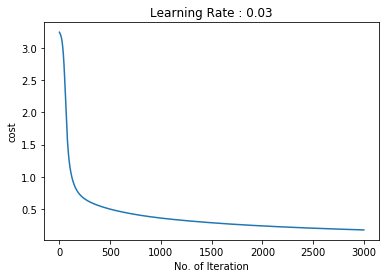

ValueError: operands could not be broadcast together with shapes (10,9999) (55,9999) 

In [20]:
layer_dims = [784, 45, 55, 10]
optimized_parameters, train_accuracy, costs = model(train_X_orig, train_Y_orig, layer_dims, learning_rate = 0.03, num_iterations = 3000, print_cost=True)


Train accuracy :  94.37823963732728
Test accuracy :  92.91929192919292
Enter any example number : 58888
Label :  1


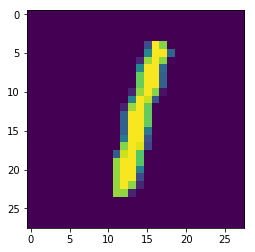

Enter any example number : 5555
Label :  6


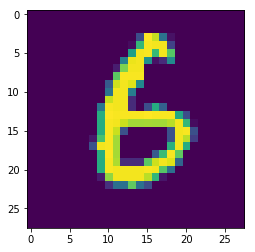

Enter any example number : 32456
Label :  9


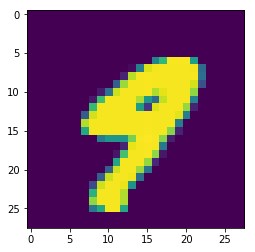

Enter any example number : 4568
Label :  1


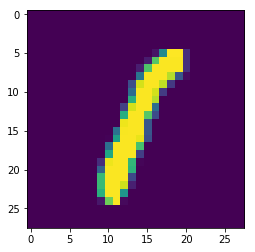

Enter any example number : 7412
Label :  2


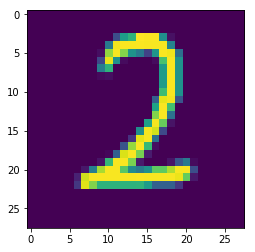

Enter any example number : -1


In [23]:
new_optimized_parameters = optimized_parameters
test_accuracy = prediction_accuracy(test_X_orig, test_Y_orig, optimized_parameters, layer_dims)

print("Train accuracy : ", train_accuracy)
print("Test accuracy : ", test_accuracy)
digit_recognizer(train_X_orig, layer_dims, new_optimized_parameters)